<p style='text-align: center'>

    <img src='images/cesi.png' width="20%">
    <div style='text-align: center'>Rima Benrejeb, Thomas Mattone, Bastien Reynaud, Badreddine Ferragh</div>
</p>


# Leyenda - Image Captioning

In [ ]:
## **Table Of Contents**
> 1. [Objective](#1)
> 2. [Data](#2)
> 3. [Notebook imports](#3)
> 4. [Importing data](#4)
> 5. [Hyper-parameters](#5)
> 6. [Deep Neural Networks](#6)
> 7. [Convolutional Neural Networks](#7)
> 8. [Improving models](#8)
> 9. [Improving training](#9)
> 10. [Transfer Learning](#10)
> 11. [Results](#11)

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

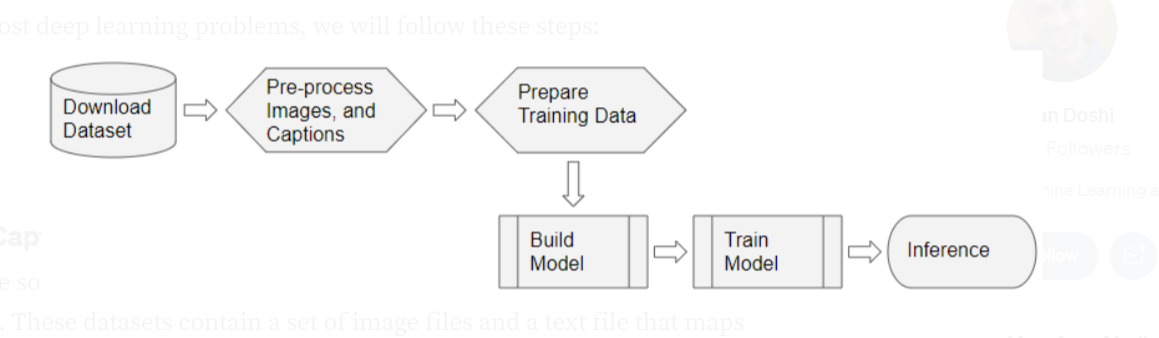

## 3. Data Preprocessing
As we have explained in the various deliverables, we must go through a preprocessing phase to be able to create an optimal dataset to train our model. To do this, we will use the MS COCO dataset to train our model. This dataset published by Microsoft means Common Objects in Context, it is widely used in the field of computer vision. Due to the fact that it contains a large number of labeled images.
### 3.1 Data Downloading
We must first load the data from the COCO dataset. We have two types of data in this case : <b> images</b> as well as <b> annotations </b>.
This dataset contains >82,000 images, each of which has been annotated with at least 5 different captions. The code code below will download and extract the dataset automatically.

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'

annotation_file = os.path.abspath('.')+"/annotations/captions_train2014.json"
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

### 3.2 Data Loading

Optionally, we chose to limit the size of the training set for faster training. <br>
For this example, we'll select a subset of 30,000 captions and use these and the corresponding images to train our model. As always, captioning quality will improve if you choose to use more data.

In [3]:
# read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)

for val in annotations['annotations']:
#     caption = f"<start> {val['caption']} <end>"
    caption = '<start> ' + val['caption'] + ' <end>'
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will 
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

print(train_captions[0])
Image.open(img_name_vector[0])

NameError: name 'annotation_file' is not defined

In [11]:
# # read the json file
# with open(annotation_file, 'r') as f:
#     annotations = json.load(f)

# # storing the captions and the image name in vectors
# all_captions = []
# all_img_name_vector = []

# for annot in annotations['annotations']:
#     caption = '<start> ' + annot['caption'] + ' <end>'
#     image_id = annot['image_id']
#     full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
    
#     all_img_name_vector.append(full_coco_image_path)
#     all_captions.append(caption)

# # shuffling the captions and image_names together
# # setting a random state
# train_captions, img_name_vector = shuffle(all_captions,
#                                           all_img_name_vector,
#                                           random_state=1)

# # selecting the first 30000 captions from the shuffled set
# num_examples = 30000
# train_captions = train_captions[:num_examples]
# img_name_vector = img_name_vector[:num_examples]

# print(train_captions[0],train_captions[1])
# Image.open(img_name_vector[0])


### 3.3 Image Preparation
Now that we have loaded our data in the correct format, we can start processing it. In this part we will focus on the case of images. In the current state, this type of data is not adequate to train our model. We must therefore transform them so that they can be interpreted as input for our final model.

We will therefore have to encode our images as a vector in a latent space. We have already seen this principle with convolution in previous notebook.

The load_image function has as input the path of an image and as output a couple containing the processed image as well as its access path.


     The load_image function has as input the path of an image and as output a couple
     containing the processed image and its access path.
     The load_image function performs the following processing:
        1. Loading the file corresponding to the path image_path
        2. Decoding of the image in RGB.
        3. Resizing the image to size (299, 299).
        4. Normalization of image pixels between -1 and 1, which matches the format of the images used to train InceptionV3.
        

In [12]:
def load_image(image_path):

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

### 3.4 Initialize InceptionV3 and load the pretrained Imagenet weights

In order to allow the network to converge faster and to only have to train the final model, we decided to use the transfer learning method. To do this we directly implemented the <b> pre-trained InceptionV3 </b>model on ImageNet.

The weights of the model are frozen which means that the model no longer learns and only processes the data that we provide to it. Also, in the last layer of the model the size of the image is of the form (8, 8, 2048). During storage in memory we resize this vector of the following form: (64, 2048). This means that for each of the 64 positions of the preprocessed image, 2048 features were extracted by InveptoinV3. And therefore, the input of the CNN decoder is a batch where each element consists of the 2048 characteristics of the 64 positions of the preprocessed image.

In [13]:
# Download the pre-trained InceptionV3 model with the ImageNet weights 
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                 weights='imagenet')
# Creation of a variable which will be the input of the new image pre-processing model
new_input = image_model.input

# retrieve the last hidden layer which contains the image in compact representation
hidden_layer = image_model.layers[-1].output

# Model that computes a dense representation of images with InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

Here, we are pre-processing each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 * 8 * 2048 floats per image.

In [14]:
# Image pre-processing

# Get unique images
encode_train = sorted(set(img_name_vector))

# Creation of an instance of "tf.data.Dataset" starting from the names of the images
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

# Divide the data into batches after applying the pre-processing done by load_image
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Walk through the dataset batch by batch to do InceptionV3 pre-processing
for img, path in tqdm(image_dataset):
    # Pre-processing of the current batch (of size (16,8,8,2048)) by InceptionV3
    batch_features = image_features_extract_model(img)
    # Resize the batch from size (16,8,8,2048) to size (16,64,2048)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    # Browse the current batch and store the path as well as the batch with np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (image path associated with its new representation, image representation)
        np.save(path_of_feature, bf.numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [07:49<00:00,  1.25s/it]


### 3.5 Preprocess and tokenize the captions
Once our images are preprocessed we can focus on our annotations. As with images, we need to transform our dataset. Indeed, we must transform our annotations into integers which act as identifiers.<br> In the code above we have carried out this processing thanks to the tokenizer class of tensorflow.

* First, we tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, we limit the vocabulary size to the top 5,000 words. We replace all other words with the token "UNK" (unknown).
* We then create word-to-index and index-to-word mappings.
* Finally, we pad all sequences to be the same length as the longest one.

In [2]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [16]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [17]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [18]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [19]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [20]:
# Compute the maximum length that is used to store attention weights
# It will be used later for display during the evaluation
max_length = calc_max_length(train_seqs)

### 3.5 Dataset Preparation
We now have preprocessed data that can be used by the different models. This part studies the creation of different datasets from these new data. <br>

To prepare the dataset, we separate it into two homogeneous subsets to avoid class underrepresentation. The first subset, called training, will allow the model to adjust its weights and consequently improve its denoising. The second allows us to evaluate the model's ability to denoise. It is on this dataset that we base ourselves for the calculation of the precision of the model.

In [21]:
### Split the data into training and testing


print(len(img_name_vector), len(cap_vector))
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

30018 30018


(24015, 24015, 6003, 6003)

We have, in this context, a voluminous data set. So in order to facilitate the representation of the dataset and facilitate the processing of this one, we decided to represent it by an instance tf.data.Dataset.
This dataset will serve us for training our model.

In [22]:
### Create a tf.data dataset for training

# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [23]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and divide data into batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## 4. Modeling
We now have a clean dataset ready to be used for model training. Therefore, this part is focused on the development and evaluation of the model.<br>


Below we have represented the final diagram of the solution. We have already talked about the Inception V3 pre-trained model earlier in this notebook. We will describe and implement the other parts of the scheme later.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

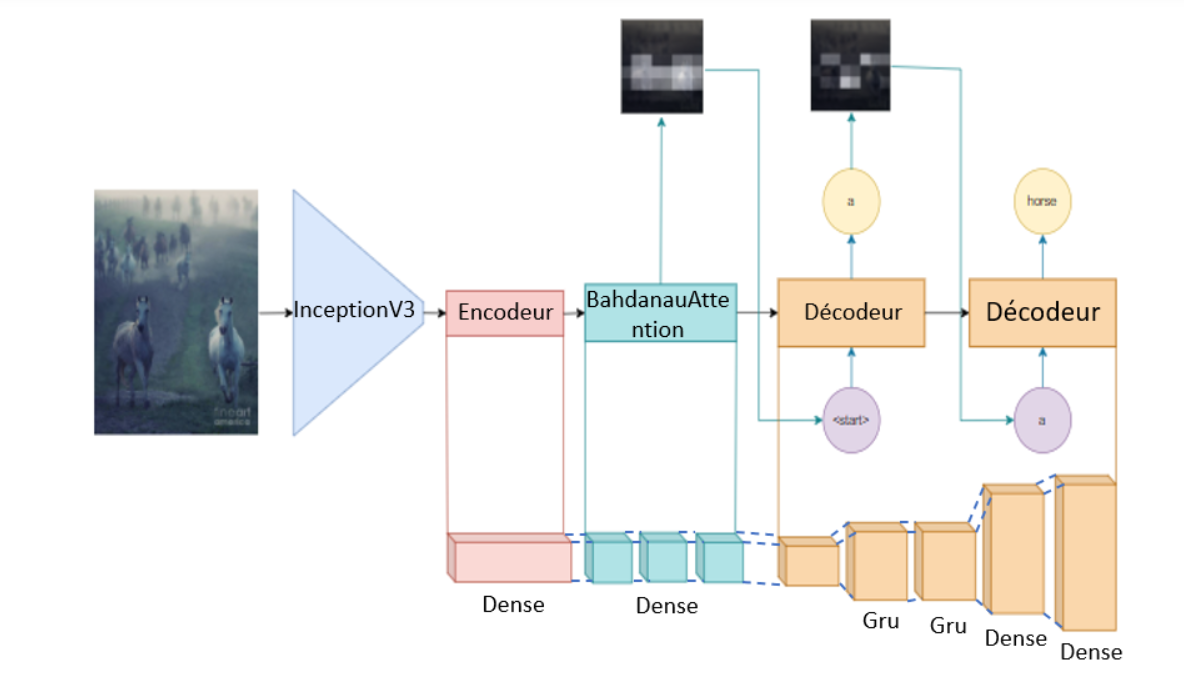

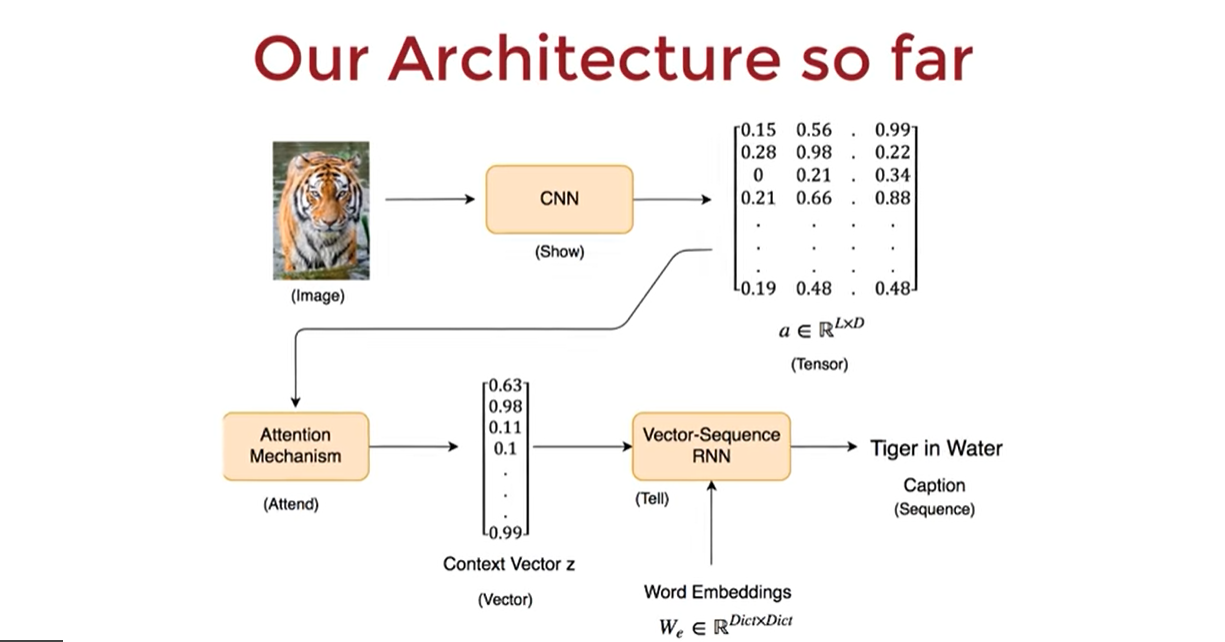

### 4.1 CNN Encoder
The role of the encoder is to produce a vector representation of the image which will be passed as input to the RNN decoder. The CNN will take the features extracted by InceptionV3 and stored on disk.

As a reminder, we had previously used the transfer learning technique to pre-process our inputs. To train the model on our problem we add a dense layer at the end. This last dense layer calculates a new representation of the image of size 64 x 256 where each position of the image has 256 features. In addition, we do not perform any flattening during our treatment.

The advantage of this representation compared to the flattened representation is to preserve spatial information at the level of the layers of the neural network. This will allow the attention mechanism of the RNN part to detect the interesting positions at the level of the image and to inform the algorithm on which zone it will have to focus the most importance to caption the image.

In [25]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### 4.2 Attention mechanism

The attention mechanism looks a lot like a classic RNN cell, but with a few differences. The attention part has as input the representation of the preprocessed image returned by the CNN as well as the current value of the hidden state of the GRU, and as output the vector of the context which reflects the most important characteristics of the image. An intermediate step to calculate this vector consists in calculating the attention weights which represent the importance of each position of the image (there are 64 of them) in the prediction of its annotation.

The representation of the image given as input is transformed at the beginning in the same way as for the CNN by passing it to a dense layer of size units. Similarly, the hidden state is also changed to a dense layer of size units. The new image representation is then summed in the hidden state and then passed to a tanh-like activation function as for classical RNN cells. At this level, we will have a representation of the data of size 64xunits containing a mixture of information on the image and on the text of the annotation. A score is then associated with each of the positions by passing this representation to a dense layer. These scores are normalized with a softmax layer to produce the vector of attention weights.

Finally, each feature of the input image representation will be multiplied (weighted) by the attention vector. After that, we take the sum of each characteristic along the positions (the lines of the representation) to form the vector of the context.

Overall, we can say that the vector of attention depends on scores that are learned from a spatial and textual representation of the image. This attention vector returns the relevance of each position and is used to calculate the vector of the context which will give us the importance of the characteristics of the image.

In [26]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### 4.3 RNN decoder
The role of the RNN decoder is to use the preprocessed representation of the image to predict its caption word by word. This GRU type single cell RNN. The GRU has a hidden state which represents the memory of the last elements seen by it. The GRU updates its state before returning it, for this it uses some memorization mechanisms which are quite sophisticated.

The decoder is structured as follows, at each call of the RNN, the current word as well as the representation of the image and the hidden state of the GRU are given as input to the RNN. As the words are represented by integers, these must be passed through a layer called the embedding layer which will be responsible for calculating a vector representation of size `output_dim` starting from the number representing the word.

Next to that, the attention mechanism provides a vector representing the context of the image, i.e. a vector that tells us about the dominant characteristics of the image. This vector is calculated by calling the attention mechanism by providing it as input the characteristics of the image encoded by the CNN as well as the hidden state of the GRU which summarizes the history of the words seen by the RNN so far. .

Then the current word and the context are concatenated to form the input vector of the GRU which in turn calculates the state in the next step. This state is passed through a dense layer of size units then the output of this layer is passed to another dense layer of size vocab_size which returns the score associated with each word of the vocabulary in order to predict the next word.

In [27]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [28]:
# defining encoder and decoder
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

## ADAM Optimizer
optimizer = tf.keras.optimizers.Adam()

# The loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
     from_logits=True, reduction='none')

def loss_function(real, pred):
     mask = tf.math.logical_not(tf.math.equal(real, 0))
     loss_ = loss_object(real, pred)

     mask = tf.cast(mask, dtype=loss_.dtype)
     loss_ *= mask

     return tf.reduce_mean(loss_)

In [29]:
# Defining Checkpoints
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

Initialization of training start epoch in start_epoch. 

The tf.train.Checkpoint class allows you to continue training where you left off if it had been interrupted before.

In [30]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

### 4.4 Training
* We extract the features stored in the respective .npy files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [35]:
loss_plot = []

In [36]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

The overall code containing the training loop is shown below. This loop goes through the training dataset batch by batch and trains the networks with them.

In [37]:
EPOCHS = 25

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 7 Batch 0 Loss 2.8775
Epoch 7 Batch 100 Loss 0.9918
Epoch 7 Batch 200 Loss 1.0809
Epoch 7 Batch 300 Loss 0.9570
Epoch 7 Loss 1.060480
Time taken for 1 epoch 734.3722412586212 sec

Epoch 8 Batch 0 Loss 0.8692
Epoch 8 Batch 100 Loss 0.8728
Epoch 8 Batch 200 Loss 0.7896
Epoch 8 Batch 300 Loss 0.7842
Epoch 8 Loss 0.816768
Time taken for 1 epoch 636.5123991966248 sec

Epoch 9 Batch 0 Loss 0.7686
Epoch 9 Batch 100 Loss 0.7601
Epoch 9 Batch 200 Loss 0.6765
Epoch 9 Batch 300 Loss 0.7514
Epoch 9 Loss 0.731258
Time taken for 1 epoch 661.2589337825775 sec

Epoch 10 Batch 0 Loss 0.6695
Epoch 10 Batch 100 Loss 0.6653
Epoch 10 Batch 200 Loss 0.6294
Epoch 10 Batch 300 Loss 0.5967
Epoch 10 Loss 0.672297
Time taken for 1 epoch 735.4227905273438 sec

Epoch 11 Batch 0 Loss 0.6811
Epoch 11 Batch 100 Loss 0.6111
Epoch 11 Batch 200 Loss 0.6072
Epoch 11 Batch 300 Loss 0.5832
Epoch 11 Loss 0.624952
Time taken for 1 epoch 768.3957650661469 sec

Epoch 12 Batch 0 Loss 0.5399
Epoch 12 Batch 100 Loss 0.5425


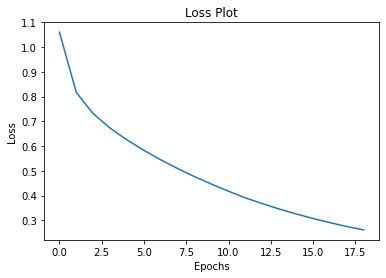

In [38]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## 5. Captioning
* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [39]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [40]:
# Function allowing the representation of attention of the image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> <unk> baseball player ready to hit the ball <end>
Prediction Caption: a young man standing on top of a game of a silly toppings <end>


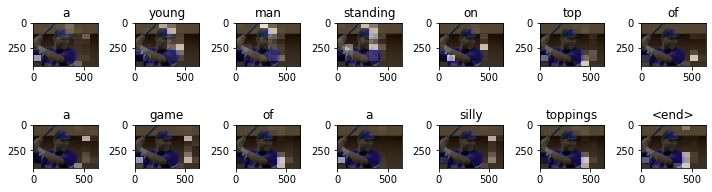

In [41]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


### 5.1 testing the model on our own images
Below, we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)

Prediction Caption: a young young boy is cutting into a small piece of cake <end>


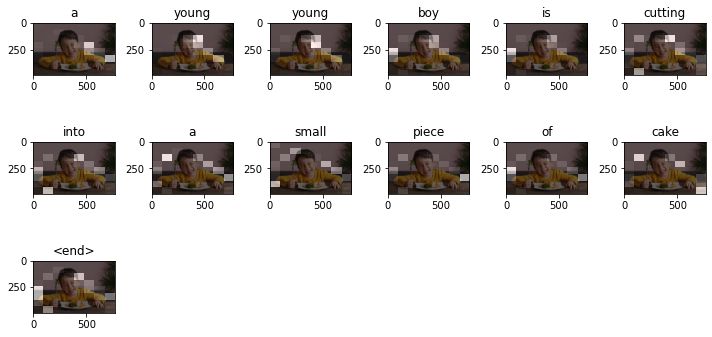

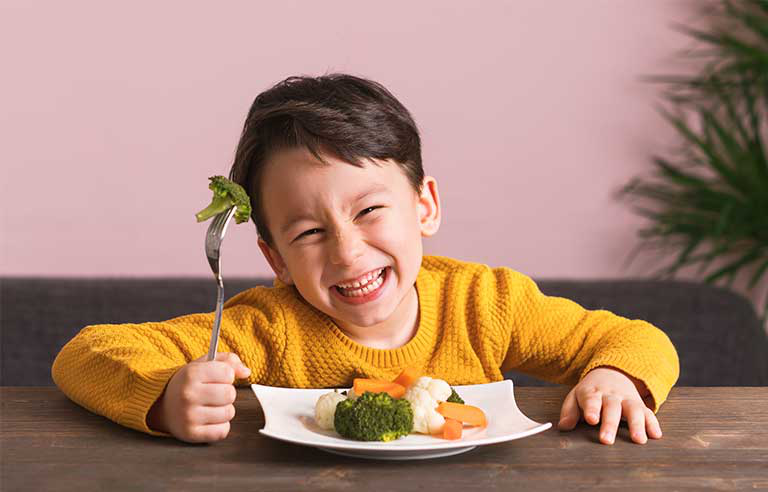

In [100]:
image_url = 'https://www.safetyandhealthmagazine.com/ext/resources/images/news/kid%20health/happy-kid.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image1'+image_extension,
                                     origin=image_url)
# image_path=
result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)


In [1]:
image_url = 'https://africanews.space/wp-content/uploads/2018/12/Tunisia.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image4'+image_extension,
                                     origin=image_url)
# image_path=
result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)


NameError: name 'tf' is not defined

##  6. USE CASE

In [46]:
import json

def save_model_training(model):
    model.save_weights(f'models/weigths/{model.name}.h5')
    with open(f'models/history/{model.name}.json', 'w') as f:
        json.dump(model.history.history, f)

In [51]:
encoder._name = 'capt_encoder'

In [53]:
encoder.save_weights(f'./{encoder.name}.h5')

In [55]:
decoder._name = 'capt_decoder'

In [56]:
decoder.save_weights(f'./{decoder.name}.h5')

In [66]:
L = []

for l in loss_plot:
    L.append(tf.get_static_value(l))

In [67]:
L

[1.0604798,
 0.81676817,
 0.73125756,
 0.6722969,
 0.62495214,
 0.5828121,
 0.544323,
 0.5088702,
 0.47612402,
 0.446027,
 0.41749895,
 0.39055604,
 0.36731738,
 0.34544885,
 0.32569215,
 0.3070974,
 0.29034427,
 0.27461985,
 0.2610092]

In [ ]:
### Training with 